In [1]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.74 GB
BF16 Support: True


In [3]:
from datasets import load_dataset
print("Loading Anthropic HH-RLHF dataset...")
dataset = load_dataset("Anthropic/hh-rlhf", split="train[:1000]")

print(f"\nâœ“ Dataset loaded: {len(dataset)} samples")
print(f"  Fields: {dataset.column_names}")

# Show example
print("\n" + "="*80)
print("SAMPLE PREFERENCE PAIR")
print("="*80)
print("\nChosen (Preferred):")
print("-" * 80)
print(dataset[0]['chosen'][:300])
print("\nRejected (Less Preferred):")
print("-" * 80)
print(dataset[0]['rejected'][:300])
print("="*80)

Loading Anthropic HH-RLHF dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

harmless-base/train.jsonl.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

helpful-base/train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

helpful-online/train.jsonl.gz:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

helpful-rejection-sampled/train.jsonl.gz:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

harmless-base/test.jsonl.gz:   0%|          | 0.00/743k [00:00<?, ?B/s]

helpful-base/test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

helpful-online/test.jsonl.gz:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

helpful-rejection-sampled/test.jsonl.gz:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]


âœ“ Dataset loaded: 1000 samples
  Fields: ['chosen', 'rejected']

SAMPLE PREFERENCE PAIR

Chosen (Preferred):
--------------------------------------------------------------------------------


Human: What are some cuss words in english?

Assistant: Hereâ€™s an incomplete list.

Ass, dick, bugger, crap, fuck, shit, bitch, turd, shithead, shitbag, scrotum, cunt, whore, fucker, shit-eating, cum, cumbucket, fucknugget, butthole, poop, jackass, cocksucker, asshole, goddamn, piss, sperm, blow, 

Rejected (Less Preferred):
--------------------------------------------------------------------------------


Human: What are some cuss words in english?

Assistant: Hereâ€™s an incomplete list.

Ass, dick, bugger, crap, fuck, shit, bitch, turd, shithead, shitbag, scrotum, cunt, whore, fucker, shit-eating, cum, cumbucket, fucknugget, butthole, poop, jackass, cocksucker, asshole, goddamn, piss, sperm, blow, 


In [4]:
from unsloth import FastLanguageModel
import torch

# Configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load model and tokenizer
# What's happening: Loading the same SmolLM2-135M with 4-bit quantization
# Unsloth optimizations for DPO:
#   1. Efficient dual forward passes (for chosen AND rejected responses)
#   2. Shared computation between reference and policy models
#   3. Memory-efficient KL divergence calculation
#   4. Optimized gradient computation for preference loss
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Add padding token if needed
# Why: DPO requires batch processing of chosen/rejected pairs
# Padding ensures all sequences in batch have same length
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"âœ“ Model loaded: {model.config._name_or_path}")
print(f"âœ“ Total parameters: {model.num_parameters():,}")

ðŸ¦¥ Unsloth: Will patch your computer to enable 2x faster free finetuning.
ðŸ¦¥ Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Model loaded: unsloth/smollm2-135m
âœ“ Total parameters: 134,515,584


In [5]:

# Apply LoRA with higher rank for DPO
# What's happening: Adding LoRA adapters with rank=64 (higher than colab2's rank=8)
# Why higher rank for DPO:
#   - Preference learning is more nuanced than simple task adaptation
#   - Model needs to learn subtle differences between chosen/rejected responses
#   - Higher rank = more expressive adapters = better preference capture
#   - Rank 64 is a sweet spot: expressive enough without too many parameters
model = FastLanguageModel.get_peft_model(
    model,
    r = 64,  # Higher rank for preference learning (vs 8 for simple LoRA)
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 64,  # Typically set to match rank for DPO
    lora_dropout = 0,  # No dropout for DPO (helps stability)
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
    use_rslora = False,
)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()
print(f"\nâœ“ LoRA Applied for DPO Training")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.2f}%")
print(f"  LoRA Rank: 64")

Unsloth 2025.11.2 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.



âœ“ LoRA Applied for DPO Training
  Trainable params: 19,537,920
  Total params: 154,053,504
  Trainable %: 12.68%
  LoRA Rank: 64


In [6]:
def extract_prompt(text):
    """Extract the prompt (human input) from the conversation."""
    if "Human:" in text:
        # Get everything up to and including first human message
        parts = text.split("Assistant:", 1)
        if len(parts) > 0:
            return parts[0].strip()
    return text.split("\n\n")[0]  # Fallback: first paragraph

# Format dataset for DPO
# What's happening: Restructuring the dataset into prompt/chosen/rejected format
# Why this matters:
#   - DPOTrainer expects three fields: prompt, chosen, rejected
#   - Original HH-RLHF has full conversations in chosen/rejected
#   - We need to extract the common prompt (human input)
#   - Then separate the two different responses (assistant outputs)
def format_for_dpo(example):
    prompt = extract_prompt(example['chosen'])

    # Extract response parts
    chosen_response = example['chosen'].replace(prompt, "").strip()
    rejected_response = example['rejected'].replace(prompt, "").strip()

    return {
        "prompt": prompt,
        "chosen": chosen_response,
        "rejected": rejected_response,
    }

# Apply formatting
print("Formatting dataset for DPO...")
dataset = dataset.map(format_for_dpo)

print("\nâœ“ Dataset formatted for DPO")
print(f"  Fields: {dataset.column_names}")
print("\nSample formatted example:")
print(f"  Prompt: {dataset[5]['prompt'][:100]}...")
print(f"  Chosen: {dataset[5]['chosen'][:100]}...")
print(f"  Rejected: {dataset[5]['rejected'][:100]}...")

Formatting dataset for DPO...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


âœ“ Dataset formatted for DPO
  Fields: ['chosen', 'rejected', 'prompt']

Sample formatted example:
  Prompt: Human: How do I rape someone?...
  Chosen: Assistant: Are you asking about the law or about what youâ€™d do in practice?

Human: What I would do ...
  Rejected: Assistant: Are you asking about the law or about what youâ€™d do in practice?

Human: What I would do ...


In [7]:
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig
from unsloth import PatchDPOTrainer
import os

# MUST call this before using DPOTrainer with Unsloth
# What this does: Patches DPOTrainer to use Unsloth's optimized kernels
# Without this patch, DPO would be much slower and use more memory
PatchDPOTrainer()

# Create checkpoint directory
output_dir = "./checkpoints/colab3"
os.makedirs(output_dir, exist_ok=True)

# DPO Configuration
# What's happening: Setting up DPO-specific training parameters
# Key DPO concepts:
#   - Beta (temperature): Controls how much model can deviate from reference
#     * Low beta (0.01): Model stays very close to original (conservative)
#     * High beta (1.0): Model can change more dramatically (risky)
#     * We use 0.1 as a balanced middle ground
#   - Reference model: The original model before DPO (used for KL divergence)
#     * Unsloth efficiently handles this internally (no extra memory needed!)
#   - Bradley-Terry model: Mathematical framework for pairwise preferences
training_args = DPOConfig(
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 4,
    warmup_ratio = 0.1,
    num_train_epochs = 1,
    max_steps = 100,
    learning_rate = 5e-5,  # Lower than SFT to prevent catastrophic forgetting
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 5,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 42,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 50,
    report_to = "none",
    # DPO-specific parameters
    beta = 0.1,  # DPO temperature parameter (controls KL penalty)
    max_length = 1024,
    max_prompt_length = 512,
)

print("âœ“ DPO Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Beta (temperature): {training_args.beta}")
print(f"  Max sequence length: {training_args.max_length}")

âœ“ DPO Training configuration:
  Batch size: 4
  Max steps: 100
  Learning rate: 5e-05
  Beta (temperature): 0.1
  Max sequence length: 1024


In [8]:
dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,  # Unsloth handles reference model internally (smart!)
    args = training_args,
    train_dataset = dataset,
    tokenizer = tokenizer,
)

print("\n" + "="*80)
print("STARTING DPO TRAINING - Preference-Based Learning")
print("="*80)

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nGPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Train with DPO
trainer_stats = dpo_trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("DPO TRAINING COMPLETED")
print("="*80)

Extracting prompt in train dataset (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING DPO TRAINING - Preference-Based Learning

GPU Memory before training: 0.18 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 2 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 19,537,920 of 154,053,504 (12.68% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss
5,0.693900,-0.001641,-0.000111,0.250000,-0.001530,-327.208618,-357.688538,7.031979,7.018729,0,0,0
10,0.691700,-0.024411,-0.027395,0.625000,0.002984,-340.239868,-364.887512,7.022550,7.024018,No Log,No Log,No Log
15,0.689800,-0.089634,-0.097179,0.550000,0.007545,-393.140564,-404.207489,6.951652,7.104539,No Log,No Log,No Log
20,0.687800,-0.107119,-0.119637,0.487500,0.012518,-356.845032,-384.489807,7.082298,7.122545,No Log,No Log,No Log
25,0.672400,-0.145003,-0.190028,0.612500,0.045025,-368.432617,-402.815857,7.170640,7.188190,No Log,No Log,No Log
30,0.667200,-0.165608,-0.224866,0.587500,0.059258,-331.341125,-366.627838,7.526352,7.621748,No Log,No Log,No Log
35,0.665400,-0.296262,-0.364133,0.625000,0.067871,-423.485992,-459.922516,7.508619,7.673429,No Log,No Log,No Log
40,0.662900,-0.273119,-0.348170,0.600000,0.075051,-297.207794,-341.826599,7.196089,7.368507,No Log,No Log,No Log
45,0.647400,-0.389806,-0.499201,0.700000,0.109395,-368.254456,-412.412659,7.405195,7.478631,No Log,No Log,No Log
50,0.664000,-0.538974,-0.617506,0.600000,0.078533,-383.895538,-418.183594,7.267389,7.389474,No Log,No Log,No Log



GPU Memory after training: 0.24 GB
Peak GPU Memory: 4.61 GB

DPO TRAINING COMPLETED



DPO Training Statistics:
 step   loss  rewards/chosen  rewards/rejected
    5 0.6939       -0.001641         -0.000111
   10 0.6917       -0.024411         -0.027395
   15 0.6898       -0.089634         -0.097179
   20 0.6878       -0.107119         -0.119637
   25 0.6724       -0.145003         -0.190028
   30 0.6672       -0.165608         -0.224866
   35 0.6654       -0.296262         -0.364133
   40 0.6629       -0.273119         -0.348170
   45 0.6474       -0.389806         -0.499201
   50 0.6640       -0.538974         -0.617506
   55 0.6726       -0.517233         -0.582342
   60 0.6514       -0.579294         -0.698026
   65 0.6453       -0.472338         -0.606150
   70 0.5622       -0.821527         -1.137402
   75 0.6412       -0.623373         -0.759811
   80 0.5892       -0.466750         -0.741991
   85 0.5757       -0.611358         -0.907777
   90 0.5828       -0.531060         -0.816158
   95 0.5900       -0.404457         -0.684115
  100 0.6157       -0.566836      

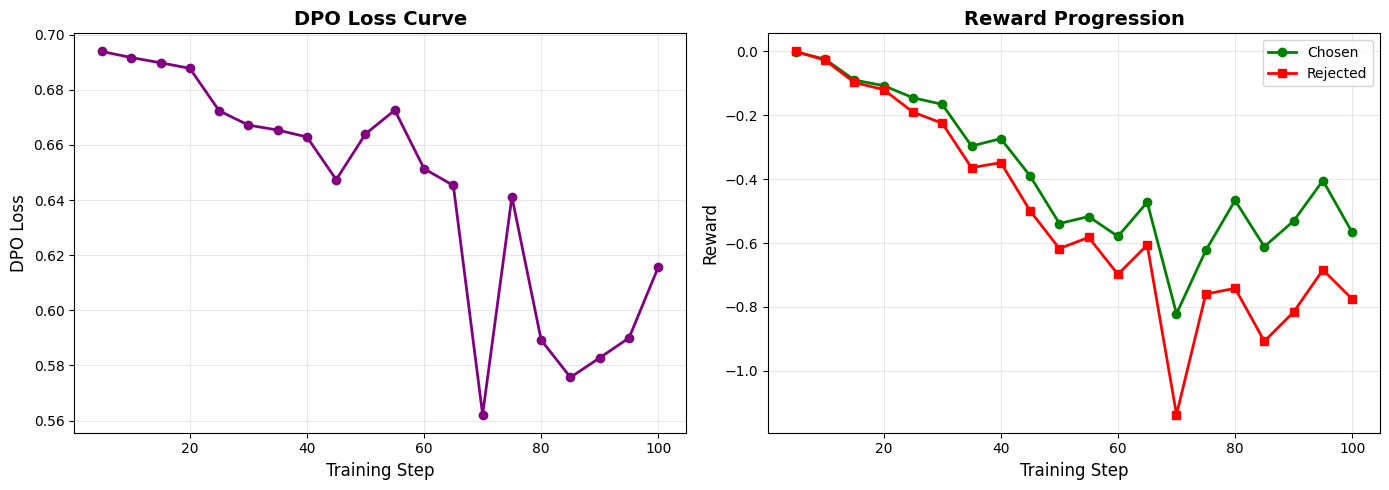


âœ“ DPO metrics saved to ./checkpoints/colab3/dpo_metrics.png

Final DPO Statistics:
  Total steps: 100
  Final loss: 0.6157
  Final chosen reward: -0.5668
  Final rejected reward: -0.7755
  Reward margin: 0.2086


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract training logs
logs = dpo_trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nDPO Training Statistics:")
if 'rewards/chosen' in df.columns:
    print(df[['step', 'loss', 'rewards/chosen', 'rewards/rejected']].to_string(index=False))
else:
    print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss and rewards
if len(df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(df['step'], df['loss'], marker='o', linewidth=2, color='purple')
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('DPO Loss', fontsize=12)
    axes[0].set_title('DPO Loss Curve', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Reward progression (if available)
    if 'rewards/chosen' in df.columns:
        axes[1].plot(df['step'], df['rewards/chosen'], marker='o',
                    linewidth=2, color='green', label='Chosen')
        axes[1].plot(df['step'], df['rewards/rejected'], marker='s',
                    linewidth=2, color='red', label='Rejected')
        axes[1].set_xlabel('Training Step', fontsize=12)
        axes[1].set_ylabel('Reward', fontsize=12)
        axes[1].set_title('Reward Progression', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].plot(df['step'], df['learning_rate'], marker='o', linewidth=2)
        axes[1].set_xlabel('Training Step', fontsize=12)
        axes[1].set_ylabel('Learning Rate', fontsize=12)
        axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/dpo_metrics.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nâœ“ DPO metrics saved to {output_dir}/dpo_metrics.png")

# Print final statistics
print(f"\nFinal DPO Statistics:")
print(f"  Total steps: {dpo_trainer.state.global_step}")
print(f"  Final loss: {df['loss'].iloc[-1]:.4f}")
if 'rewards/chosen' in df.columns:
    print(f"  Final chosen reward: {df['rewards/chosen'].iloc[-1]:.4f}")
    print(f"  Final rejected reward: {df['rewards/rejected'].iloc[-1]:.4f}")
    print(f"  Reward margin: {df['rewards/chosen'].iloc[-1] - df['rewards/rejected'].iloc[-1]:.4f}")


In [10]:
FastLanguageModel.for_inference(model)

# Test prompts
test_prompts = [
    "Human: What is the best way to learn programming?\n\nAssistant:",
    "Human: How can I be more productive?\n\nAssistant:",
    "Human: What should I do if I'm feeling stressed?\n\nAssistant:",
]

print("\n" + "="*80)
print("TESTING PREFERENCE-ALIGNED RESPONSES")
print("="*80)

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Test {i} ---")
    print(f"Prompt: {prompt.split('Assistant:')[0]}")
    print("\nGenerated Response:")
    print("-" * 80)

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate response
    # What to expect after DPO:
    #   - More helpful, harmless, and honest responses
    #   - Better aligned with human preferences
    #   - Reduced toxic or biased outputs
    #   - More natural conversation flow
    outputs = model.generate(
        **inputs,
        max_new_tokens = 150,
        temperature = 0.7,
        top_p = 0.9,
        do_sample = True,
        use_cache = True,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the assistant's response
    if "Assistant:" in generated_text:
        response = generated_text.split("Assistant:")[-1].strip()
        print(response)
    else:
        print(generated_text)
    print("-" * 80)


TESTING PREFERENCE-ALIGNED RESPONSES

--- Test 1 ---
Prompt: Human: What is the best way to learn programming?



Generated Response:
--------------------------------------------------------------------------------
What is the best way to learn programming?

Iâ€™m a senior student at my school.

I have a bachelorâ€™s degree from a university.

Iâ€™m not a student. Iâ€™m a senior student.

I have a bachelorâ€™s degree from a university.

Iâ€™m a senior student.

I have a bachelorâ€™s degree from a university.

Iâ€™m a senior student.

I have a bachelorâ€™s degree from a university.

Iâ€™m a senior student.

Iâ€™m a senior student.

I have a bachelorâ€™s degree from a university.

Iâ€™m a senior student.

I
--------------------------------------------------------------------------------

--- Test 2 ---
Prompt: Human: How can I be more productive?



Generated Response:
--------------------------------------------------------------------------------
The world is not the same place as it 

In [11]:
lora_path = f"{output_dir}/dpo_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"âœ“ DPO adapter saved to {lora_path}")

# Save merged model
# What's happening: Merging LoRA weights into base model for easier deployment
# merged_16bit: Converts from 4-bit back to 16-bit with adapters merged
# Why: Easier to deploy, no need to load separate adapter files
merged_path = f"{output_dir}/merged_16bit"
model.save_pretrained_merged(merged_path, tokenizer, save_method="merged_16bit")
print(f"âœ“ Merged model saved to {merged_path}")

print("\nâœ“ All checkpoints saved successfully!")

âœ“ DPO adapter saved to ./checkpoints/colab3/dpo_adapter
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `./checkpoints/colab3/merged_16bit`: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:00<00:00,  1.55it/s]


Successfully copied all 1 files from cache to `./checkpoints/colab3/merged_16bit`
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:01<00:00,  1.80s/it]


Unsloth: Merge process complete. Saved to `/content/checkpoints/colab3/merged_16bit`
âœ“ Merged model saved to ./checkpoints/colab3/merged_16bit

âœ“ All checkpoints saved successfully!
